In [ ]:
# Pennylane

try:
    import pennylane as qml
except ImportError:
    %pip install pennylane
    import pennylane as qml

from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

import math

n_qubits = 4  # Number of system qubits.
acc = 3 # Number of digits of accuracy
n_shots = 10 ** (acc*2)  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
q_delta = 0.1  # Initial spread of random quantum weights

dev = qml.device("lightning.qubit", wires=tot_qubits)

# q_delta = 0.1 => 31 iterations
# q_delta = 0.001 =>
eps = 0.01 # Required epsilon for minimizer thresholding

# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([2.5, -1, -1, -0.5])

A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
            A_num[m, n] = -1

b = np.ones(2**n_qubits) / np.sqrt(2**n_qubits)

print("A = \n", np.real(A_num))
print("b = \n", b)
cond = np.linalg.cond(A_num)
print(str(cond))
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

def CU_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.ctrl(qml.Hadamard, control=ancilla_idx)(wires=idx)

def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

# Defines an C_i matrix, which will comprise an L2 matrix for the
# high-entanglement decomposition of the Poisson
def CI(i):
    for j in range(i):
        qml.MultiControlledX(wires=[ancilla_idx, i, i-1-j])
    qml.MultiControlledX(wires=[ancilla_idx] + [x for x in range(i)] + [i])
    for j in range(i):
        qml.MultiControlledX(wires=[ancilla_idx, i, j])

# L3 tilda matrix for the high-entanglement decomposition of the poisson
# THIS ONE IS THE REASON THE RESULTS HAVE TO BE REVERSED.
# eventually we will want to invert this so we don't have to reverse the outputs
def L3():
    qml.Hadamard(wires=ancilla_idx)
    qml.MultiControlledX(wires=[x for x in range(n_qubits+1)])
    qml.Hadamard(wires=ancilla_idx)

    for i in range(n_qubits):
        qml.CNOT(wires=[ancilla_idx, i])

    qml.Hadamard(wires=ancilla_idx)
    qml.MultiControlledX(wires=[x for x in range(n_qubits+1)])
    qml.Hadamard(wires=ancilla_idx)

    for i in range(n_qubits):
        qml.CNOT(wires=[ancilla_idx, i])


def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        # L1
        qml.CNOT(wires=[ancilla_idx, 0])

    elif idx == 2:
        # L2 matrix
        for i in range(1, n_qubits):
            CI(i)

    elif idx == 3:
        # L3tilda matrix
        L3()
"""
def variational_block(weights):
    if len(weights) != (n_qubits-1):
        print("EXP VAR BLOCK. WRONG WEIGHT")

    qml.Hadamard(wires=[n_qubits-1])

    for q in range(n_qubits-1):
        qml.RY(weights[q], wires=q)
        qml.CNOT(wires=[n_qubits-1, q])

def c_variational_block(weights):
    if len(weights) != (n_qubits-1):
        print("EXP VAR BLOCK. WRONG WEIGHT")

    qml.ctrl(qml.Hadamard, control=ancilla_idx)(wires=(n_qubits-1))

    for q in range(n_qubits-1):
        qml.ctrl(qml.RY, control=ancilla_idx)(weights[q], wires=q)
        qml.MultiControlledX(wires=[n_qubits-1, ancilla_idx, q])
"""
def variational_block(weights):
    #Variational circuit mapping the ground state |0> to the ansatz state |x>.
    num_layers = 3
    if len(weights) != 3*n_qubits: print("WRONG WEIGHTS")
    U_b()

    # Using num_layers layers for variational ansatz
    for layer in range(num_layers):
        # Layer of rotation gates
        for idx, element in enumerate(weights[layer*n_qubits:(layer+1)*n_qubits]):
            qml.RY(element, wires=idx)

        # Applying entanglement layer to all but the last layer
        if layer < (num_layers-1):
            for idx in range(n_qubits):
                # Essentially vary the entanglement by the number
                # of layers we choose for the ansatz.
                if layer != idx:
                    qml.CZ(wires=[layer, idx])

def c_variational_block(weights):
    #Variational circuit mapping the ground state |0> to the ansatz state |x>.
    num_layers = 3

    CU_b()

    # Using num_layers layers for variational ansatz
    for layer in range(num_layers):
        # Layer of rotation gates
        for idx, element in enumerate(weights[layer*n_qubits:(layer+1)*n_qubits]):
            qml.ctrl(qml.RY, control=ancilla_idx)(element, wires=idx)

        # Applying entanglement layer to all but the last layer
        if layer < (num_layers-1):
            for idx in range(n_qubits):
                # Essentially vary the entanglement by the number
                # of layers we choose for the ansatz.
                if layer != idx:
                    qml.Hadamard(wires=ancilla_idx)
                    qml.MultiControlledX(wires=[layer, idx, ancilla_idx])
                    qml.Hadamard(wires=ancilla_idx)


def had_one(dev, weights, l):
    # For calculating < b | psi >
    @qml.qnode(dev, interface="autograd")
    def _had_one(weights, l):

        qml.Hadamard(wires=ancilla_idx)

        # Initial state = | 0 >
        # Unitary to control = U_b_adj A_l V
        c_variational_block(weights)

        CA(l)

        CU_b()

        qml.Hadamard(wires=ancilla_idx)

        return qml.expval(qml.PauliZ(wires=ancilla_idx))
    return _had_one(weights, l)

def mu(weights, l):
    global tqc
    tqc += 1

    mu_real = had_one(dev, weights, l)

    return mu_real

def b_psi_sq(weights):

    res = 0

    for l in range(len(c)):
        res += c[l] * mu(weights, l)

    return abs(res ** 2)

def had_two(dev, weights, l, lp):
    # For calculating < psi | psi >
    @qml.qnode(dev, interface="autograd")
    def _had_two(weights, l, lp):

        qml.Hadamard(wires=ancilla_idx)

        # Initial state = V | 0 >
        variational_block(weights)

        # Unitary to control = A_lp_adj A_l
        CA(l)
        CA(lp) # Hermitian/Pauli matrices are self-adjoint

        qml.Hadamard(wires=ancilla_idx)

        return qml.expval(qml.PauliZ(wires=ancilla_idx))
    return _had_two(weights, l, lp)

def beta(weights, l, lp):
    global tqc
    tqc += 1

    beta_real = had_two(dev, weights, l, lp)

    return beta_real

def psi_psi(weights):

    res = 0

    # Add all l and lp s.t. l != lp and lp > l
    for l in range(len(c)):
        for lp in range(l+1, len(c)):
            res += 2 * c[l] * np.conj(c[lp]) * beta(weights, l, lp)

    # Add the remaining result of the summations
    for ind in range(len(c)):
        res += c[ind] * np.conj(c[ind])

    return abs(res)

def cost_loc(weights):
    global cost, w
    w = weights

    b_psi_sq_val = b_psi_sq(weights)
    psi_psi_val = psi_psi(weights)

    # Toss out runs where b_psi_sq is larger than psi_psi, as
    # we know that is physically impossible.
    #while b_psi_sq_val > psi_psi_val:
    #    b_psi_sq_val = b_psi_sq(weights)
    #    psi_psi_val = psi_psi(weights)

    cost = 1 - (b_psi_sq_val/psi_psi_val)
    return cost

global tqc
tqc = 0

cost_loc([0 for x in range(n_qubits*3)])
print(n_qubits)
print(tqc)

A = 
 [[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1

In [ ]:
# GRAPHING COST FUNCTION FOR N=2

values = range(int(2*np.pi*(10**2)))

res = []
ind = 0
for x in values:
     print(ind)
     ind += 1
     res += [cost_loc([x*(10**(-2))])]

plt.plot([float(x*(10**(-2))) for x in values], res)
plt.title("Global Cost Function Surface")
plt.xlabel("$\\theta$")
plt.ylabel("Cost")
plt.show()

In [ ]:
# TRYING TO FIND OPTIMAL INITIAL WEIGHTS

def neg_cost(weights):
    return - cost_loc(weights)

from scipy.optimize import minimize

class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print("Cost: " + str(cost))
    #if cost <= gamma:
    #    raise GammaCondition

cost_history = []

global cost, w

n_qubits = 7 # Number of system qubits.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
gamma = (eps ** 2) / (n_qubits * cond ** 2)

dev = qml.device("lightning.qubit", wires=tot_qubits)

n_shots = 10**7
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

#w = np.pi*np.random.rand(n_qubits*num_layers)

# EXP WEIGHT/VAR BLOCK
w = np.pi*np.random.rand(n_qubits-1)
#w = [1 for x in range((n_qubits-1))]


method = 'Powell'

print("Qubits: " + str(n_qubits))
print("Method: " + str(method))
print("Weights: " + str(w))

try:
    out = minimize(cost_loc, x0 = w, method=method, callback=log_cost)
except GammaCondition:
    pass

print("Final weights " + str(w))
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []

for sam in raw_samples:
    sam1 = list(sam)
    sam1.reverse()
    samples.append(int("".join(str(bs) for bs in sam1), base=2))

q_probs = np.bincount(samples) / n_shots

q_probs = list(q_probs)

#q_probs = q_probs[int(len(q_probs)/2):] + q_probs[:int(len(q_probs)/2)]
#q_max = max(q_probs)
#q_min = min(q_probs)
#q_probs = [q_max - x + q_min for x in q_probs]
if len(q_probs) < 2**n_qubits:
    q_probs.append(0)

A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
            A_num[m, n] = -1

b = np.ones(2**n_qubits) / np.sqrt(2**n_qubits)

print("A = \n", np.real(A_num))
print("b = \n", b)
cond = np.linalg.cond(A_num)
print(str(cond))
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

print("x_n^2 =\n", c_probs)
print("|<x|n>|^2=\n", q_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

q_probs = list(q_probs)
while len(q_probs) < 2**n_qubits:
    q_probs.append(0)
ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

In [ ]:
from scipy.optimize import minimize
q_delta = 0.1
gamma = (eps ** 2) / (cond ** 2)

class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print(cost)
    if cost <= gamma:
        raise GammaCondition

opts = ["L-BFGS-B", "CG", "Powell"]
global w

#w = [-0.22296879,  1.39700563, -1.86268021, -1.69595003,  1.33466046,  0.58702013,
# -1.37133891, -0.31573189,  1.67787141]
cost_history_all = []
for opt in opts:
    best_cost = 10
    best_hist = []
    print(opt)
    for num in range(10):
        cost_history = []
        print("Trial: " + str(num+1))
        w = q_delta * np.random.rand(9)
        try:
            out = minimize(cost_loc, x0 = w, method=opt, callback=log_cost)
        except GammaCondition:
            pass
        if cost_history[len(cost_history)-1] < best_cost:
            best_hist = cost_history
            best_cost = best_hist[len(best_hist)-1]

    cost_history_all.append(best_hist)



In [ ]:
for ind in range(len(opts)):
    plt.loglog(cost_history_all[ind], label=opts[ind])
plt.ylabel("Cost Function Value")
plt.xlabel("Optimization steps")
plt.title("Cost Function Value vs. Iterations, Global Cost Function")
plt.legend()
plt.show()

4
A = 
 [[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

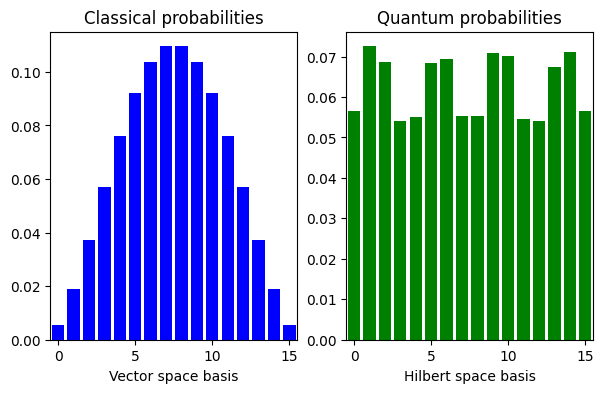

5
A = 
 [[ 2. -1.  0. ...  0.  0.  0.]
 [-1.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2. -1.]
 [ 0.  0.  0. ...  0. -1.  2.]]
b = 
 [0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767]
440.68856038364817
0.9844800613650248
0.9736788865957038
0.9702401836612624
0.9684490613083122
0.9665741278435707


KeyboardInterrupt: 

In [ ]:
# TESTING MULTI-QUBIT SYSTEMS

from scipy.optimize import minimize

qubits_list = [x for x in range(4, 11)]


class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print(cost)
    if cost <= gamma:
        raise GammaCondition

global w

cost_history_all = []
for q in qubits_list:
    cost_history = []
    print(q)
    w = q_delta * np.random.rand(q*3)

    n_qubits = q  # Number of system qubits.
    tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
    ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).

    dev = qml.device("lightning.qubit", wires=tot_qubits)

    A_num = np.zeros((2**n_qubits, 2**n_qubits))
    for idx in range(2**n_qubits):
        A_num[idx, idx] = 2

    for m in range(2**n_qubits):
        for n in range(2**n_qubits):
            if abs(m - n) == 1:
                A_num[m, n] = -1

    b = np.ones(2**q) / np.sqrt(2**q)

    print("A = \n", np.real(A_num))
    print("b = \n", b)
    cond = np.linalg.cond(A_num)
    print(str(cond))
    A_inv = np.linalg.inv(A_num)
    x = np.dot(A_inv, b)

    c_probs = (x / np.linalg.norm(x)) ** 2

    gamma = (eps ** 2) / (cond ** 2)

    try:
        out = minimize(cost_loc, x0 = w, method="Powell", callback=log_cost)
    except GammaCondition:
        pass
    cost_history_all.append(cost_history)

    dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)
    @qml.qnode(dev_x, interface="autograd")
    def prepare_and_sample(weights):

        # Variational circuit generating a guess for the solution vector |x>
        variational_block(weights)

        # We assume that the system is measured in the computational basis.
        # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
        # this will be repeated for the total number of shots provided (n_shots)
        return qml.sample()
    raw_samples = prepare_and_sample(w)

    # convert the raw samples (bit strings) into integers and count them
    samples = []
    for sam in raw_samples:
        sam1 = list(sam)
        sam1.reverse()
        samples.append(int("".join(str(bs) for bs in sam1), base=2))

    q_probs = np.bincount(samples) / n_shots

    print("x_n^2 =\n", c_probs)
    print("|<x|n>|^2=\n", q_probs)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

    ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
    ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
    ax1.set_xlabel("Vector space basis")
    ax1.set_title("Classical probabilities")

    q_probs = list(q_probs)
    if len(q_probs) < 2**q:
        q_probs.append(0)
    ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
    ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
    ax2.set_xlabel("Hilbert space basis")
    ax2.set_title("Quantum probabilities")

    plt.show()

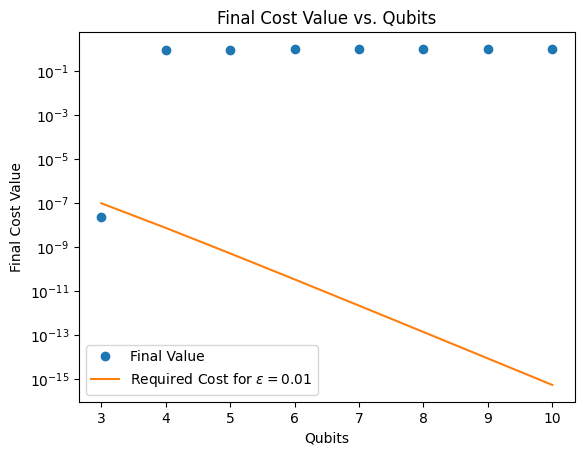

In [ ]:
cond_nums = [32, 116, 440, 1711, 6743, 26767, 106657, 425801]
eps = 0.01
plt.semilogy(qubits_list, [abs(x[len(x)-1]) for x in cost_history_all], 'o', label="Final Value")
plt.semilogy(qubits_list, [ eps ** 2 / (cond_nums[x-3]**2) for x in range(3, 11)], label="Required Cost for $\epsilon=0.01$")
plt.title("Final Cost Value vs. Qubits")
plt.xlabel("Qubits")
plt.ylabel("Final Cost Value")
plt.legend()
plt.show()

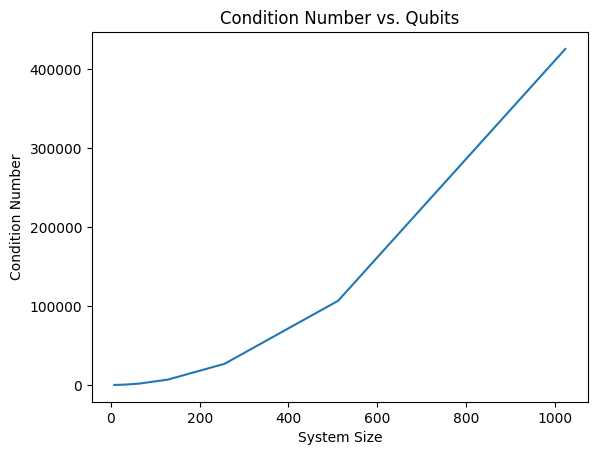

In [ ]:
cond_nums = [32, 116, 440, 1711, 6743, 26767, 106657, 425801]
plt.plot(2**np.array(qubits_list), cond_nums)
plt.title("Condition Number vs. Qubits")
plt.xlabel("System Size")
plt.ylabel("Condition Number")
plt.show()

Number of iterations:
83
Final weights:
[-0.87282238  1.48418873 -2.01721859 -2.39910419  1.11443047  0.94585525
 -1.47505986 -0.61686477  1.88664007]
Target
9.666629739898855e-08
x_n^2 =
 [0.03252033 0.0995935  0.16463415 0.20325203 0.20325203 0.16463415
 0.0995935  0.03252033]
|<x|n>|^2=
 [0.032345 0.099281 0.164876 0.203501 0.202554 0.164753 0.099985 0.032705]


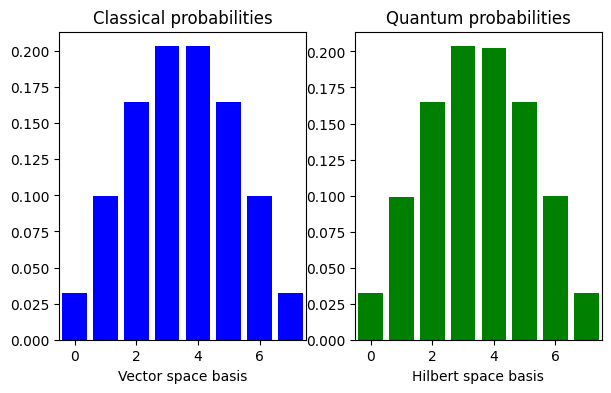

In [ ]:
# For verifying results

print("Number of iterations:")
print(len(cost_history))
print("Final weights:")
print(w)
print("Target")
print(gamma)

n_shots = 10**6
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    sam1 = list(sam)
    sam1.reverse()
    samples.append(int("".join(str(bs) for bs in sam1), base=2))

q_probs = np.bincount(samples) / n_shots

print("x_n^2 =\n", c_probs)
print("|<x|n>|^2=\n", q_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), list(q_probs), color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

In [ ]:
A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
                A_num[m, n] = -1

b = np.ones(8)/np.sqrt(8)

A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)
c_probs = (x / np.linalg.norm(x))
print("true soln: " + str(c_probs))

x = [0, 0, 0.5, 0.5, 0.5, 0.5, 0, 0]
print("but for some reason it gives me this soln: " + str(x))
res = np.dot(A_num, x)
print("why does it think this is b " + str(res))
print("when it should be this " + str(b))
print(np.dot(res, b)/np.linalg.norm(res))


true soln: [0.18033393 0.31558437 0.40575134 0.45083482 0.45083482 0.40575134
 0.31558437 0.18033393]
but for some reason it gives me this soln: [0, 0, 0.5, 0.5, 0.5, 0.5, 0, 0]
why does it think this is b [ 0.  -0.5  0.5  0.   0.   0.5 -0.5  0. ]
when it should be this [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
0.0
